In [3]:
import os
import scipy.io
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# Converting boxcars into indexes

In [4]:
def load_cache(path, encoding="latin-1", fix_imports=True):
        """
        encoding latin-1 is default for Python2 compatibility
        """
        with open(path, "rb") as f:
            return pickle.load(f, encoding=encoding, fix_imports=True)
        
def create_unique_ann_list():
        
        for data in dataset['samples']:
            new_ann = data['annotation']
            if new_ann not in cars_annotations:
                cars_annotations.append(new_ann)

def convert_ann_to_num(ann):
    if ann not in cars_annotations:
        cars_annotations.append(ann)
    return cars_annotations.index(ann)

In [5]:
cars_annotations = []
split = load_cache('../data/BoxCars/classification_splits.pkl')['hard']
dataset = load_cache('../data/BoxCars/dataset.pkl')
atlas = load_cache('../data/BoxCars/atlas.pkl')

create_unique_ann_list()
print('Number of annotations ' + str(len(cars_annotations)))

Number of annotations 693


In [6]:
def get_unique_list(li):
    return list(set(li))

def create_unique_multitask_list():    
    make = []
    mode = []
    submodel = []
    generation = []
    
    for new_ann in cars_annotations:
        t_make,t_model,t_submodel,t_generation = new_ann.split()
        make.append(t_make)
        mode.append(t_model)
        submodel.append(t_submodel)
        generation.append(t_generation)
    return get_unique_list(make),get_unique_list(mode),get_unique_list(submodel),get_unique_list(generation)
make,model,submodel,generation = create_unique_multitask_list()

In [7]:
print("make:",len(make))
print("model:",len(model))
print("submodel:",len(submodel))
print("generation:",len(generation))

make: 45
model: 338
submodel: 11
generation: 11


In [8]:
def separate_classes():
    arr = []
    for idx, annotation in enumerate(cars_annotations):
        make,model,submodel,generation = annotation.split()
        arr.append((idx, annotation,make, model, submodel, generation))
    arr = pd.DataFrame(arr, columns=['target', 'full_annotation','make', 'model', 'submodel', 'generation'])
    return arr
v2_info = separate_classes()

In [9]:
make_codes = v2_info['make'].astype('category').cat.codes
make_codes

0      35
1      35
2      35
3      35
4      35
       ..
688    14
689    31
690    41
691     7
692    28
Length: 693, dtype: int8

The hard split contains 107 fine-grained classes 
11 653 tracks (51 691 images) for training and 11 125 tracks (39 149 images)
for testing

In [10]:
import scipy.io
def load_anno(path):
    mat = scipy.io.loadmat(path)
    return mat

def load_class_names(path="/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/StanfordCars/devkit/cars_meta.mat"):
    cn = load_anno(path)['class_names']
    cn = cn.tolist()[0]
    cn = [str(c[0].item()) for c in cn]
    return cn

test = load_class_names()

In [11]:
test

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi A5 Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi V8 Sedan 1994',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi TT Hatchback 2011',
 'Audi S6 Sedan 2011',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S4 Sedan 2012',
 'Audi S4 Sedan 2007',
 'Audi TT RS Coupe 2012',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW X5 SUV 2007',
 'BMW X6 SUV 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3

In [12]:
def load_annotations_v2(path, v2_info):
    ann = load_anno(path)['annotations'][0]
    ret = {}
    make_codes = v2_info['make'].astype('category').cat.codes
    type_codes = v2_info['model_type'].astype('category').cat.codes

    for idx in range(len(ann)):
        x1, y1, x2, y2, target, imgfn = ann[idx]

        r = {
            'x1': x1.item(),
            'y1': y1.item(),
            'x2': x2.item(),
            'y2': y2.item(),
            'target': target.item() - 1,
            'make_target': make_codes[target.item() - 1].item(),
            'type_target': type_codes[target.item() - 1].item(),
            'filename': imgfn.item()
        }

        ret[idx] = r
    return ret

# Adding Augmentations to images

In [13]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import random


#%%
def alter_HSV(img, change_probability = 0.6):
    if random.random() < 1-change_probability:
        return img
    addToHue = random.randint(0,179)
    addToSaturation = random.gauss(60, 20)
    addToValue = random.randint(-50,50)
    hsvVersion =  cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    channels = hsvVersion.transpose(2, 0, 1)
    channels[0] = ((channels[0].astype(int) + addToHue)%180).astype(np.uint8)
    channels[1] = (np.maximum(0, np.minimum(255, (channels[1].astype(int) + addToSaturation)))).astype(np.uint8)
    channels[2] = (np.maximum(0, np.minimum(255, (channels[2].astype(int) + addToValue)))).astype(np.uint8)
    hsvVersion = channels.transpose(1,2,0)   
        
    return cv2.cvtColor(hsvVersion, cv2.COLOR_HSV2RGB)

#%%
def image_drop(img, change_probability = 0.6):
    if random.random() < 1-change_probability:
        return img
    width = random.randint(int(img.shape[1]*0.10), int(img.shape[1]*0.3))
    height = random.randint(int(img.shape[0]*0.10), int(img.shape[0]*0.3))
    x = random.randint(int(img.shape[1]*0.10), img.shape[1]-width-int(img.shape[1]*0.10))
    y = random.randint(int(img.shape[0]*0.10), img.shape[0]-height-int(img.shape[0]*0.10))
    img[y:y+height,x:x+width,:] = (np.random.rand(height,width,3)*255).astype(np.uint8)
    return img

#%%
def add_bb_noise_flip(image, bb3d, flip, bb_noise):
    bb3d = bb3d + bb_noise 
    if flip:
        bb3d[:, 0] = image.shape[1] - bb3d[:,0]
        image = cv2.flip(image, 1)
    return image, bb3d

#%%
def _unpack_side(img, origPoints, targetSize):
    origPoints = np.array(origPoints).reshape(-1,1,2)
    targetPoints = np.array([(0,0), (targetSize[0],0), (0, targetSize[1]), 
                             (targetSize[0], targetSize[1])]).reshape(-1,1,2).astype(origPoints.dtype)
    m, _ = cv2.findHomography(origPoints, targetPoints, 0)
    resultImage = cv2.warpPerspective(img, m, targetSize)
    return resultImage
    
    
#%%    
def unpack_3DBB(img, bb):
    frontal = _unpack_side(img, [bb[0], bb[1], bb[4], bb[5]], (75,124))
    side = _unpack_side(img, [bb[1], bb[2], bb[5], bb[6]], (149,124))
    roof = _unpack_side(img, [bb[0], bb[3], bb[1], bb[2]], (149,100))
    final = np.zeros((224,224,3), dtype=frontal.dtype)
    final[100:, 0:75] = frontal
    final[0:100, 75:] = roof
    final[100:, 75:] = side
    
    return final

In [14]:
def get_vehicle_instance_data(vehicle_id, instance_id, original_image_coordinates=False):
    """
    original_image_coordinates: the 3DBB coordinates are in the original image space
                                to convert them into cropped image space, it is necessary to subtract instance["3DBB_offset"]
                                which is done if this parameter is False. 
    """
    vehicle = dataset["samples"][vehicle_id]
    instance = vehicle["instances"][instance_id]
    bb3d = instance["3DBB"]

    return vehicle, instance, bb3d


In [15]:
def get_image(vehicle_id, instance_id):
    return cv2.cvtColor(cv2.imdecode(atlas[vehicle_id][instance_id], 1), cv2.COLOR_BGR2RGB)

In [23]:
path = '/Users/martinodonnell/Documents/uni/fourth_year/4006/LowResImageRecognision/data/BoxCars/images/'

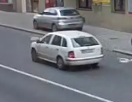

In [32]:
vehicle_id, instance_id,bb3d = get_vehicle_instance_data(0,0)
# image = get_image(0,0)
image = Image.open(path + instance_id['path'])
#Convert from pil to cv
image = np.array(image)

# image = alter_HSV(image,1) # randomly alternate color
# image = image_drop(image,1) # randomly remove part of the image
# bb_noise = np.clip(np.random.randn(2) * 1.5, -5, 5) # generate random bounding box movement
# flip = bool(random.getrandbits(1)) # random flip
# image, bb3d = add_bb_noise_flip(image, bb3d, flip, bb_noise) 

# image = unpack_3DBB(image, bb3d) 
# image = (image.astype(np.float32) - 116)/128.

# # Image.fromarray(image)
